<h1 align=center><font size = 5> Lọc và cân bằng cự ly </font></h1>

In [1]:
import sys
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os.path as path
lib_path =  path.abspath(path.join('' ,"../../api/common"))
sys.path.insert(1, lib_path)
from transform_split_data import transform_split_data
from predict import predict, evaluate
from filter_outlier import filter_outlier_value_range

%load_ext autotime
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")


time: 109 ms


### <span style="color:blue">1.Load data</span>

In [2]:
# Load dữ liệu
df = pd.read_csv('..\\pre_process_data\\pre_process_data.csv', encoding='utf-8')
data_df = df.copy()
data_df

,id$Year,id$MonthDay,id$JyoCD,id$Kaiji,id$Nichiji,id$RaceNum,race_id,Year,Month,RaceInfo$TokuNum,...,KS_SikakuCD,KS_MinaraiCD,KS_TozaiCD,KS_Syotai,KS_ChokyosiCode,CH_SexCD,CH_TozaiCD,CH_Syotai,top3,speed
0,2008,105,6,1,1,1,1,2008,1,0,...,2.0,0.0,1.0,,0.0,1,1,,0,57.446809
1,2008,105,6,1,1,1,1,2008,1,0,...,1.0,0.0,1.0,,0.0,1,1,,1,58.496953
2,2008,105,6,1,1,1,1,2008,1,0,...,2.0,0.0,1.0,,0.0,1,1,,1,58.221024
3,2008,105,6,1,1,1,1,2008,1,0,...,2.0,0.0,1.0,,0.0,1,1,,0,57.676903
4,2008,105,6,1,1,1,1,2008,1,0,...,2.0,0.0,1.0,,0.0,1,1,,1,58.457375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494336,2018,520,8,3,10,12,35925,2018,5,0,...,2.0,0.0,2.0,,0.0,1,2,,1,58.378378
494337,2018,520,8,3,10,12,35925,2018,5,0,...,2.0,0.0,2.0,,0.0,1,2,,0,57.857143
494338,2018,520,8,3,10,12,35925,2018,5,0,...,1.0,3.0,2.0,,1009.0,1,2,,0,57.754011
494339,2018,520,8,3,10,12,35925,2018,5,0,...,1.0,0.0,2.0,,411.0,1,2,,0,57.497782


time: 5.55 s


In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494341 entries, 0 to 494340
Data columns (total 78 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id$Year                      494341 non-null  int64  
 1   id$MonthDay                  494341 non-null  int64  
 2   id$JyoCD                     494341 non-null  int64  
 3   id$Kaiji                     494341 non-null  int64  
 4   id$Nichiji                   494341 non-null  int64  
 5   id$RaceNum                   494341 non-null  int64  
 6   race_id                      494341 non-null  int64  
 7   Year                         494341 non-null  int64  
 8   Month                        494341 non-null  int64  
 9   RaceInfo$TokuNum             494341 non-null  int64  
 10  RaceInfo$Nkai                494341 non-null  int64  
 11  GradeCD                      494341 non-null  object 
 12  JyokenInfo$SyubetuCD         494341 non-null  int64  
 13 

- Phân bố trên toàn tập train

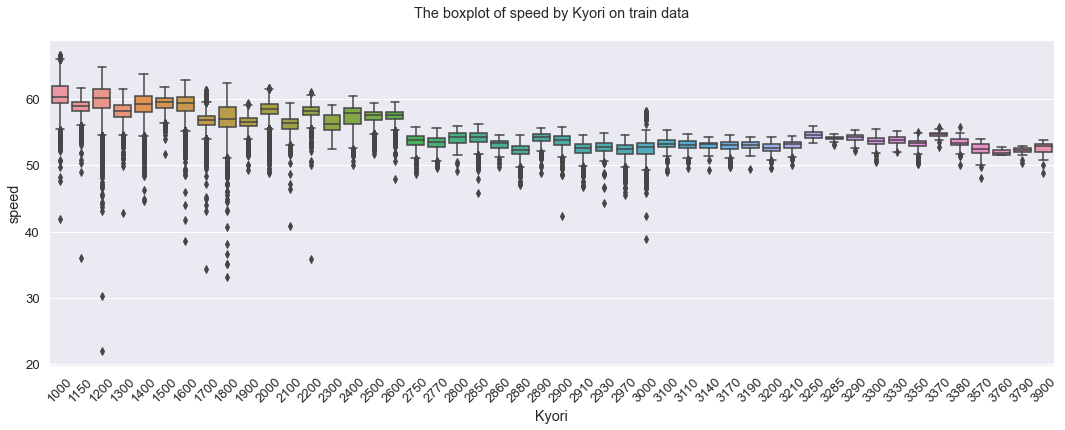

time: 1.39 s


In [4]:
# Vẽ biểu đồ box phân bố tốc độ theo các loại cự ly
sns.set(font_scale=1.2, style='darkgrid')
plt.figure(figsize=(18, 6))
ax = sns.boxplot(x='Kyori', y="speed", data=data_df);
plt.title('The boxplot of speed by Kyori on train data', y=1.05)
plt.xlabel('Kyori')
plt.ylabel('speed');
plt.setp(ax.get_xticklabels(), rotation=45);

### <span style="color:blue">2. Tạo dữ liệu lọc tốc độ thấp theo cự ly </span>  

In [5]:
train_data = df.copy()
train_data = train_data[train_data['id$Year']<2018] 
threshold = 0.1
list_Kyori = train_data['Kyori'].unique()
for Kyori in list_Kyori:
    threshold_speed =train_data[train_data['Kyori']==Kyori]['speed'].quantile(q=threshold)
    train_data.drop(train_data[(train_data['Kyori'] == Kyori)&(train_data['speed'] < threshold_speed)].index, inplace=True) 
train_data                      

,id$Year,id$MonthDay,id$JyoCD,id$Kaiji,id$Nichiji,id$RaceNum,race_id,Year,Month,RaceInfo$TokuNum,...,KS_SikakuCD,KS_MinaraiCD,KS_TozaiCD,KS_Syotai,KS_ChokyosiCode,CH_SexCD,CH_TozaiCD,CH_Syotai,top3,speed
1,2008,105,6,1,1,1,1,2008,1,0,...,1.0,0.0,1.0,,0.0,1,1,,1,58.496953
2,2008,105,6,1,1,1,1,2008,1,0,...,2.0,0.0,1.0,,0.0,1,1,,1,58.221024
3,2008,105,6,1,1,1,1,2008,1,0,...,2.0,0.0,1.0,,0.0,1,1,,0,57.676903
4,2008,105,6,1,1,1,1,2008,1,0,...,2.0,0.0,1.0,,0.0,1,1,,1,58.457375
6,2008,105,6,1,1,1,1,2008,1,0,...,1.0,0.0,1.0,,0.0,1,1,,0,58.142665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475191,2017,1228,9,5,9,12,34534,2017,12,0,...,2.0,0.0,2.0,,0.0,1,2,,1,61.992620
475192,2017,1228,9,5,9,12,34534,2017,12,0,...,2.0,0.0,2.0,,0.0,1,2,,0,61.165049
475193,2017,1228,9,5,9,12,34534,2017,12,0,...,2.0,0.0,2.0,,0.0,1,2,,0,61.538462
475194,2017,1228,9,5,9,12,34534,2017,12,0,...,1.0,0.0,2.0,,0.0,1,1,,0,60.943168


time: 9.22 s


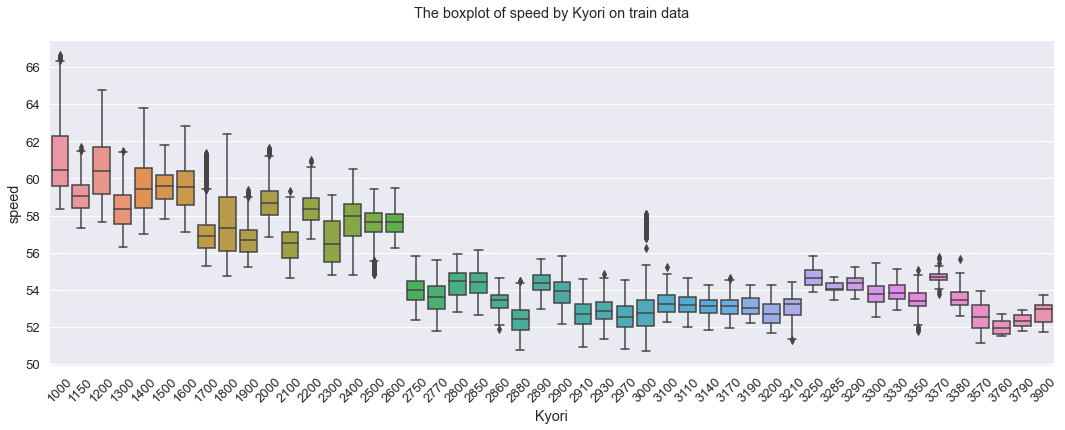

time: 1.33 s


In [6]:
# Vẽ biểu đồ box phân bố tốc độ theo các loại cự ly
sns.set(font_scale=1.2, style='darkgrid')
plt.figure(figsize=(18, 6))
ax = sns.boxplot(x='Kyori', y="speed", data=train_data);
plt.title('The boxplot of speed by Kyori on train data', y=1.05)
plt.xlabel('Kyori')
plt.ylabel('speed');
plt.setp(ax.get_xticklabels(), rotation=45);

### <span style="color:blue">3. Cân bằng số lượng trận đấu theo cự ly </span>  

In [7]:
Kyori_df = train_data[['race_id', 'KettoNum', 'Kyori']]
Kyori_df

,race_id,KettoNum,Kyori
1,1,2005102028,1200
2,1,2005104156,1200
3,1,2005105319,1200
4,1,2005101044,1200
6,1,2005103612,1200
...,...,...,...
475191,34534,2012101892,1400
475192,34534,2013104774,1400
475193,34534,2012101704,1400
475194,34534,2012102404,1400


time: 157 ms


In [8]:
y = Kyori_df['Kyori']
Counter(y).most_common()

[(1800, 94123),
 (1200, 90571),
 (1400, 59347),
 (1600, 47799),
 (2000, 36345),
 (1700, 33121),
 (1000, 15155),
 (2400, 8490),
 (2200, 6708),
 (1150, 4451),
 (1300, 4298),
 (2600, 3976),
 (2100, 3922),
 (1900, 2955),
 (3000, 2441),
 (1500, 1927),
 (2500, 1594),
 (2970, 1527),
 (2880, 1381),
 (2910, 1293),
 (2850, 1183),
 (2750, 621),
 (2900, 551),
 (3170, 514),
 (2300, 484),
 (2890, 424),
 (3110, 402),
 (2770, 350),
 (3200, 308),
 (3100, 290),
 (3300, 257),
 (2930, 219),
 (3350, 150),
 (2800, 147),
 (3380, 122),
 (3330, 118),
 (3140, 106),
 (2860, 105),
 (3570, 100),
 (3290, 81),
 (3210, 79),
 (3190, 69),
 (3900, 44),
 (3250, 40),
 (3790, 30),
 (3370, 22),
 (3760, 14),
 (3285, 11)]

time: 203 ms


In [12]:
number_samples = 20000
list_Kyori = Kyori_df['Kyori'].unique()
data = pd.DataFrame([])
for Kyori in list_Kyori:
    my_df = Kyori_df[Kyori_df['Kyori']==Kyori]
    rate = number_samples / len(my_df)
    replace = False
    if rate >=1:
        replace = True
    my_df = my_df.sample(frac=rate, replace=replace).reset_index(drop=True)
    data = data.append(my_df, ignore_index=True)
data

,race_id,KettoNum,Kyori
0,22122,2009103322,1200
1,16279,2007105563,1200
2,25168,2012102374,1200
3,21375,2011106150,1200
4,12820,2009100419,1200
...,...,...,...
959995,33275,2009103514,2860
959996,29845,2010102928,2860
959997,33410,2011106314,2860
959998,29845,2011101189,2860


time: 532 ms


In [13]:
data.drop('Kyori', axis=1, inplace=True)
new_train_data = pd.merge(data, train_data, on=['race_id', 'KettoNum'], how='left')
new_train_data.dropna(inplace=True)
new_train_data

,race_id,KettoNum,id$Year,id$MonthDay,id$JyoCD,id$Kaiji,id$Nichiji,id$RaceNum,Year,Month,...,KS_SikakuCD,KS_MinaraiCD,KS_TozaiCD,KS_Syotai,KS_ChokyosiCode,CH_SexCD,CH_TozaiCD,CH_Syotai,top3,speed
0,22122,2009103322,2014,525,4,1,8,9,2014,5,...,1.0,1.0,1.0,,1097.0,1,1,,0,57.831325
1,16279,2007105563,2012,915,6,4,3,10,2012,9,...,1.0,0.0,1.0,,0.0,1,1,,0,59.178082
2,25168,2012102374,2015,418,3,1,3,5,2015,4,...,1.0,0.0,1.0,,0.0,1,1,,0,59.340659
3,21375,2011106150,2014,315,6,2,5,4,2014,3,...,1.0,0.0,1.0,,0.0,1,1,,0,59.586207
4,12820,2009100419,2011,924,6,4,5,1,2011,9,...,1.0,0.0,1.0,,386.0,1,1,,0,61.016949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959995,33275,2009103514,2017,819,10,2,7,4,2017,8,...,1.0,0.0,2.0,,0.0,1,2,,0,54.047244
959996,29845,2010102928,2016,820,10,2,7,4,2016,8,...,1.0,0.0,2.0,,0.0,1,2,,1,54.047244
959997,33410,2011106314,2017,902,10,2,11,1,2017,9,...,3.0,0.0,2.0,,0.0,1,2,,0,54.189474
959998,29845,2011101189,2016,820,10,2,7,4,2016,8,...,1.0,0.0,1.0,,1102.0,1,1,,0,53.181818


time: 5.14 s


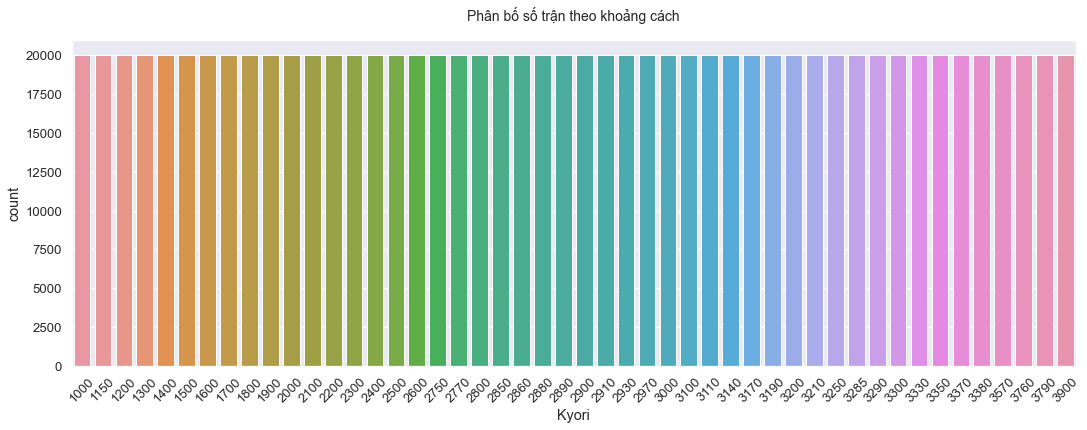

time: 1.03 s


In [14]:
plt.figure(figsize=(18, 6))
ax = sns.countplot(x="Kyori", data=new_train_data)
plt.title('Phân bố số trận theo khoảng cách', size=14, y=1.04);
plt.setp(ax.get_xticklabels(), rotation=45);

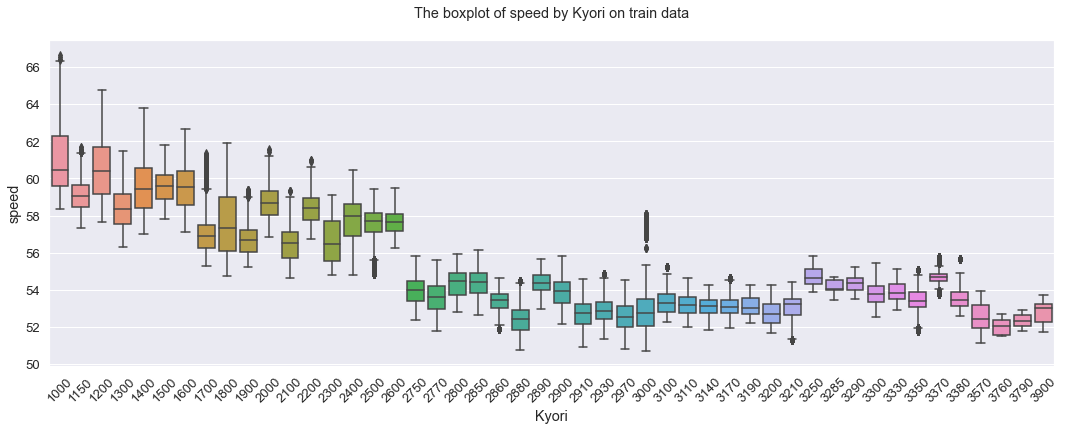

time: 1.44 s


In [15]:
# Vẽ biểu đồ box phân bố tốc độ theo các loại cự ly
sns.set(font_scale=1.2, style='darkgrid')
plt.figure(figsize=(18, 6))
ax = sns.boxplot(x='Kyori', y="speed", data=new_train_data);
plt.title('The boxplot of speed by Kyori on train data', y=1.05)
plt.xlabel('Kyori')
plt.ylabel('speed');
plt.setp(ax.get_xticklabels(), rotation=45);

In [16]:
data.to_csv('filter_balance_id.csv', index=False)

time: 1.45 s
